In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

Datetime
2002-02-12 21:29:56    25.0
2002-02-12 21:44:08    12.0
2002-02-13 00:53:24    12.0
2002-02-13 04:22:52    25.0
2002-02-13 07:03:52    50.0
                       ... 
2018-02-09 16:41:28    12.0
2018-02-09 18:15:56    12.0
2018-02-10 13:04:36    12.0
2018-02-26 15:49:56    12.0
2018-03-03 04:04:08    12.0
Name: EnergiaMax, Length: 116143, dtype: float64


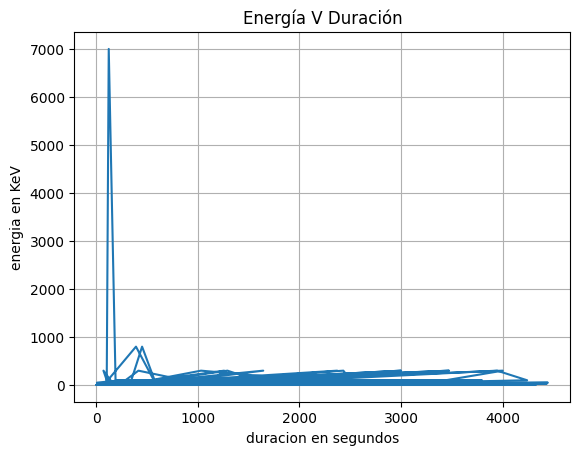

In [3]:
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
df.head()
#organizo en otros dataframes las columnas de duracion.s y energia.kev en orden descendente
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
print(df['EnergiaMax'])
#df2=df.sort_values(by=['duration.s'],ascending=False)
#df3=df.sort_values(by=['energy.kev'],ascending=False)
#Mirando los datos y de que tipo son
#print(df3['energy.kev'],df2['duration.s'])
#df2[['duration.s','energy.kev']]
#TypeEner=df['energy.kev'].dtypes
#print(TypeEner)
#imprimo la grafica
#plt.plot(df['duration.s'],df['EnergiaMin'])
#plt.title('Energía V Duración')
#plt.xlabel('duracion en segundos')
#plt.ylabel('energia en KeV')
#plt.grid()

